<a href="https://colab.research.google.com/github/Spacewalker69/Neural_Type_Transfer/blob/main/Neural_style_trasnfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In this initial part of the project, we are setting up the environment and importing the necessary libraries to create a Neural Style Transfer application. We begin by importing standard libraries such as NumPy for numerical computations, OS for file management, and Matplotlib for visualization. Additionally, we include OpenCV for image processing and TensorFlow for building our neural network**

**We also suppress any warning messages that might appear during the code execution. As our journey into Neural Style Transfer requires a combination of libraries, these initial steps ensure a smooth and focused development process**

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf

import keras
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential, Model
from keras.layers import Dense, LeakyReLU, Reshape, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Conv2DTranspose

from tensorflow.compat.v1.keras.layers import BatchNormalization

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!chmod 600 /root/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d ikarus777/best-artworks-of-all-time

 99% 2.28G/2.29G [00:35<00:00, 105MB/s] 
100% 2.29G/2.29G [00:35<00:00, 69.2MB/s]


In [5]:
import zipfile
zip_ref = zipfile.ZipFile('/content/best-artworks-of-all-time.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

**In this code snippet, we define a function named vgg_layers. This function takes a list of layer_names as input and returns a pre-trained VGG19 model with specific layers extracted.**

We start by loading the pre-trained VGG19 model from the tf.keras.applications module. The argument include_top=False means that we exclude the fully connected layers at the top of the network, and weights='imagenet' initializes the model with weights trained on the ImageNet dataset.

To prevent the weights from being updated during our project's training process, we set vgg.trainable to False.

We extract the output tensors corresponding to the specified layer names using a list comprehension. This allows us to capture the feature maps at those layers.

Finally, we create a new model using the input of the original VGG19 model and the extracted output tensors. This model will serve as our feature extraction model, which is crucial for implementing Neural Style Transfer.

In [6]:
def vgg_layers(layer_names):
    # Load the pre-trained VGG19 model with weights from 'imagenet' dataset
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

    # Freeze the weights of the VGG19 model to avoid training
    vgg.trainable = False

    # Extract the output tensors corresponding to the specified layer names
    outputs = [vgg.get_layer(name).output for name in layer_names]

    # Create a new model that takes VGG19's input and outputs the specified layers
    model = tf.keras.Model([vgg.input], outputs)

    return model

**In this section, we define the layers that will play a pivotal role in our Neural Style Transfer process. By identifying specific content and style layers within the pre-trained VGG19 model, we establish the foundation for extracting meaningful features from both content and style images. These layers will guide the synthesis of a unique artistic blend.**

content_layers: This list contains the layer name 'block5_conv2'. This layer will be used to extract content features from the content image. Content features capture the high-level structure and information of an image.

style_layers: This list contains the names of five layers: 'block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', and 'block5_conv1'. These layers will be utilized to extract style features from the style image. Style features capture artistic elements like colors, textures, and patterns.

In [7]:
content_layers = ['block5_conv2']
style_layers = [
  'block1_conv1',
  'block2_conv1',
  'block3_conv1',
  'block4_conv1',
  'block5_conv1',
]

**In this code snippet, we define a function named gram_matrix. This function calculates the Gram matrix for a given input tensor, which is a crucial step in extracting style features from an image.**

The core idea behind calculating the Gram matrix is to capture the relationships between different channels (features) in a given layer's feature map. This matrix provides insights into the textures and patterns present in the style image.

tf.linalg.einsum is a powerful function that performs Einstein summation over specified dimensions of tensors. In our case, it computes the inner product of feature maps within the input tensor.

The shape of the input tensor is retrieved using tf.shape(input_tensor). This shape includes the batch size, height, width, and number of channels.

The variable num_locations is calculated as the product of the height and width of the feature map, representing the total number of spatial locations.

Finally, we normalize the computed Gram matrix by dividing it by the num_locations. This normalization ensures that the scale of the Gram matrix remains consistent across different feature maps, regardless of their dimensions.

In [8]:
def gram_matrix(input_tensor):
    # Compute the inner product of feature maps for style representation
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)

    # Get the shape of the input tensor
    input_shape = tf.shape(input_tensor)

    # Calculate the total number of spatial locations in the feature map
    num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)

    # Divide the result by the number of locations to normalize the Gram matrix
    return result / num_locations

**In this portion, we define three essential functions: style_content_loss, clip_0_1, and train_step. These functions play integral roles in training the Neural Style Transfer model and computing the style-content loss during the optimization process.**

The style_content_loss function calculates the overall loss for Neural Style Transfer. It computes separate losses for style and content, then combines them with specified weights to create the final loss.

Inside style_loss, we loop through the style output layers and calculate the mean squared difference between the style outputs and the corresponding style targets.

The style loss is scaled by dividing it by the number of style layers for fairness.

In content_loss, we loop through the content output layers and calculate the mean squared difference between the content outputs and the content targets.

Similar to the style loss, the content loss is scaled by dividing it by the number of content layers.

The final loss is computed by summing the scaled style and content losses.

The clip_0_1 function restricts pixel values of an image to the [0, 1] range, ensuring image consistency during optimization.

The train_step function performs a single optimization step. It computes the gradients of the loss with respect to the input image using a gradient tape.

The gradients are then applied to the image using the specified optimizer, which gradually modifies the image to minimize the loss.

Finally, the pixel values of the image are clipped to ensure they stay within the [0, 1] range.

In [10]:
def style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([
        tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
        for name in style_outputs.keys()
    ])
    style_loss *= style_weight / len(style_outputs)

    content_loss = tf.add_n([
        tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
        for name in content_outputs.keys()
    ])
    content_loss *= content_weight / len(content_outputs)

    loss = style_loss + content_loss
    return loss

def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def train_step(image, extractor, style_targets, content_targets, style_weight, content_weight, optimizer):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(outputs, style_targets, content_targets, style_weight, content_weight)
    grad = tape.gradient(loss, image)
    optimizer.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

**This implementation defines a NeuralStyleTransferModel class that encapsulates the style transfer process, including loading, processing, and optimizing images. The call method performs the style transfer optimization process, iterating over a set number of iterations to update the content image towards the desired stylized output.**

**Remember to adjust the paths to the style and content images as needed and fine-tune parameters like the learning rate and number of iterations according to your specific requirements.**

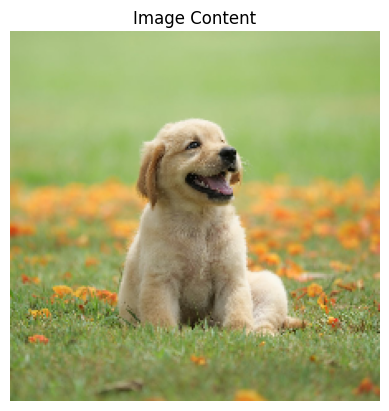

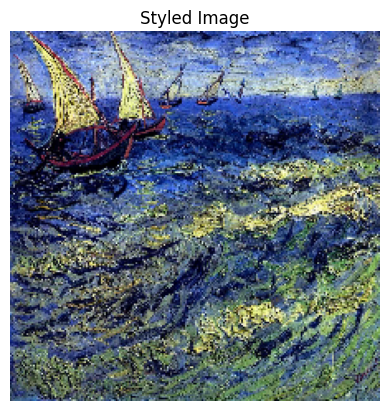

In [247]:
import tensorflow as tf

class NeuralStyleTransferModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers, style_weight, content_weight):
        super(NeuralStyleTransferModel, self).__init__()
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.style_weight = 1e-2
        self.content_weight = 1e4
        self.extractor = VGGStyleContentModel(style_layers, content_layers)

    def compile(self):
        super(NeuralStyleTransferModel, self).compile()

    def call(self, inputs):
        content_image, style_image = inputs

        style_targets = self.extractor(style_image)['style']
        content_targets = self.extractor(content_image)['content']

        image = tf.Variable(content_image)

        opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

        num_iterations =   2000 # Adjust this based on your requirements

        for _ in range(num_iterations):
            self.train_step(image, style_targets, content_targets, opt)

        final_image = image.numpy()
        return final_image

    def gram_matrix(self, input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
        return result / num_locations

    def style_content_loss(self, outputs, style_targets, content_targets):
        style_outputs = outputs['style']
        content_outputs = outputs['content']

        style_loss = tf.add_n([
            tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
            for name in style_outputs.keys()
        ])
        style_loss *= self.style_weight / len(style_outputs)

        content_loss = tf.add_n([
            tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
            for name in content_outputs.keys()
        ])
        content_loss *= self.content_weight / len(content_outputs)

        loss = style_loss + content_loss
        return loss

    def train_step(self, image, style_targets, content_targets, optimizer):
        with tf.GradientTape() as tape:
            outputs = self.extractor(image)
            loss = self.style_content_loss(outputs, style_targets, content_targets)
        grad = tape.gradient(loss, image)
        optimizer.apply_gradients([(grad, image)])

# Example usage
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layers = ['block5_conv2']
style_weight = 1e-2
content_weight = 1e4

model = NeuralStyleTransferModel(style_layers, content_layers, style_weight, content_weight)

style_image = tf.image.decode_image(tf.io.read_file('/content/images/images/Vincent_van_Gogh/Vincent_van_Gogh_100.jpg'))
content_image = tf.image.decode_image(tf.io.read_file('/content/dog-puppy-on-garden-royalty-free-image-1586966191.jpg'))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
#style_image = (style_image - 0.5) * 2.0

content_image = tf.image.convert_image_dtype(content_image, tf.float32)
#content_image = (content_image - 0.5) * 2.0

style_image = tf.image.resize(style_image, (224, 224))
content_image = tf.image.resize(content_image, (224, 224))
plt.imshow(content_image)
plt.title("Image Content")
plt.axis('off')  # Turn off axis labels
plt.show()
plt.imshow(style_image)
plt.title("Styled Image")
plt.axis('off')  # Turn off axis labels
plt.show()
#style_image = tf.keras.applications.vgg19.preprocess_input(style_image)
#content_image = tf.keras.applications.vgg19.preprocess_input(content_image)

# Add batch dimension
style_image = tf.expand_dims(style_image, axis=0)
content_image = tf.expand_dims(content_image, axis=0)
final_image = model([content_image, style_image])


In [234]:
import matplotlib.pyplot as plt
final_image = final_image[0]
final_image[:, :, 0] += 103.939
final_image[:, :, 1] += 116.779
final_image[:, :, 2] += 123.68

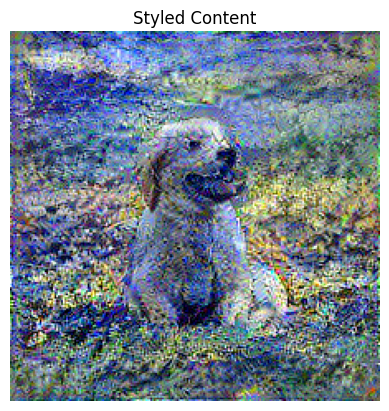

In [248]:

#final_image = final_image[:, :, ::-1]

#final_image = np.clip(final_image, 0, 255).astype('uint8')
# Convert the final_image from [-1, 1] to [0, 1] range
final_image_display = ((final_image[0]))

# Display the final image
plt.imshow(final_image_display)
plt.title("Styled Content")
plt.axis('off')  # Turn off axis labels
plt.show()

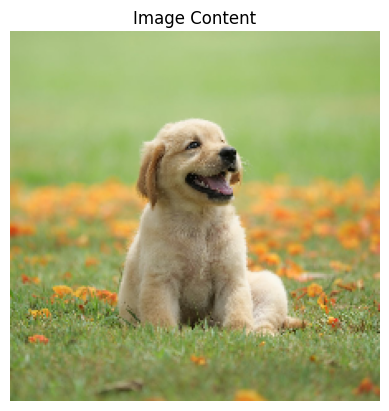

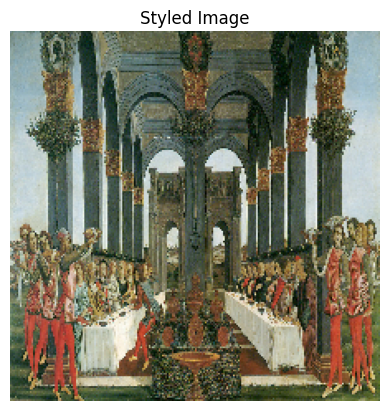

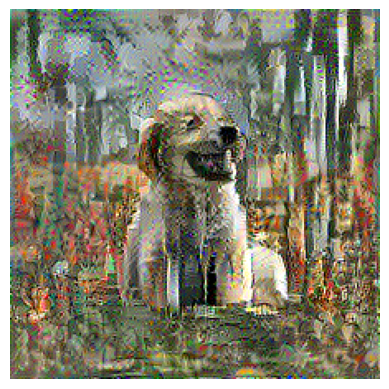

In [249]:

style_image = tf.image.decode_image(tf.io.read_file('/content/images/images/Sandro_Botticelli/Sandro_Botticelli_10.jpg'))
content_image = tf.image.decode_image(tf.io.read_file('/content/dog-puppy-on-garden-royalty-free-image-1586966191.jpg'))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
#style_image = (style_image - 0.5) * 2.0

content_image = tf.image.convert_image_dtype(content_image, tf.float32)
#content_image = (content_image - 0.5) * 2.0

style_image = tf.image.resize(style_image, (224, 224))
content_image = tf.image.resize(content_image, (224, 224))
#style_image = tf.keras.applications.vgg19.preprocess_input(style_image)
#content_image = tf.keras.applications.vgg19.preprocess_input(content_image)
plt.imshow(content_image)
plt.title("Image Content")
plt.axis('off')  # Turn off axis labels
plt.show()
plt.imshow(style_image)
plt.title("Styled Image")
plt.axis('off')  # Turn off axis labels
plt.show()
# Add batch dimension
style_image = tf.expand_dims(style_image, axis=0)
content_image = tf.expand_dims(content_image, axis=0)
final_image = model([content_image, style_image])
final_image_display = ((final_image[0]))

# Display the final image
plt.imshow(final_image_display)
plt.axis('off')  # Turn off axis labels
plt.show()

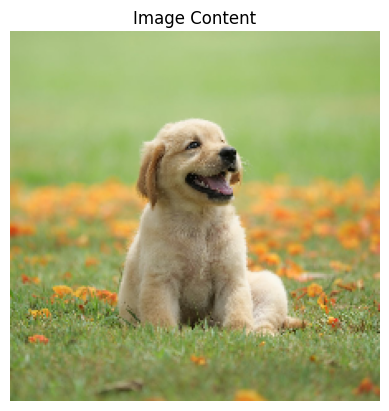

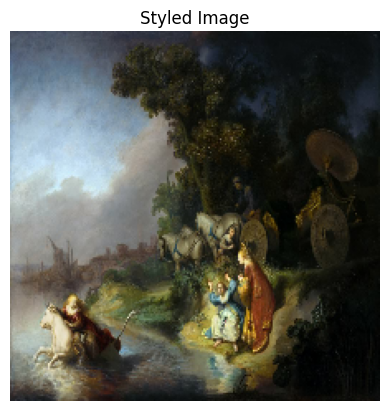

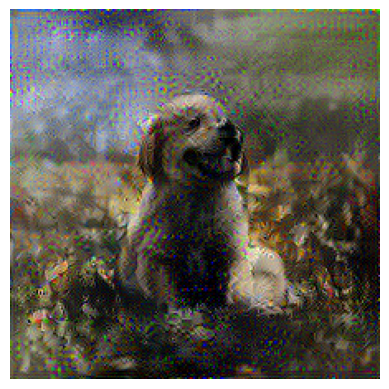

In [255]:

style_image = tf.image.decode_image(tf.io.read_file('/content/images/images/Rembrandt/Rembrandt_108.jpg'))
content_image = tf.image.decode_image(tf.io.read_file('/content/dog-puppy-on-garden-royalty-free-image-1586966191.jpg'))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
#style_image = (style_image - 0.5) * 2.0

content_image = tf.image.convert_image_dtype(content_image, tf.float32)
#content_image = (content_image - 0.5) * 2.0

style_image = tf.image.resize(style_image, (224, 224))
content_image = tf.image.resize(content_image, (224, 224))
#style_image = tf.keras.applications.vgg19.preprocess_input(style_image)
#content_image = tf.keras.applications.vgg19.preprocess_input(content_image)
plt.imshow(content_image)
plt.title("Image Content")
plt.axis('off')  # Turn off axis labels
plt.show()
plt.imshow(style_image)
plt.title("Styled Image")
plt.axis('off')  # Turn off axis labels
plt.show()
# Add batch dimension
style_image = tf.expand_dims(style_image, axis=0)
content_image = tf.expand_dims(content_image, axis=0)
final_image = model([content_image, style_image])
final_image_display = ((final_image[0]))

# Display the final image
plt.imshow(final_image_display)
plt.axis('off')  # Turn off axis labels
plt.show()

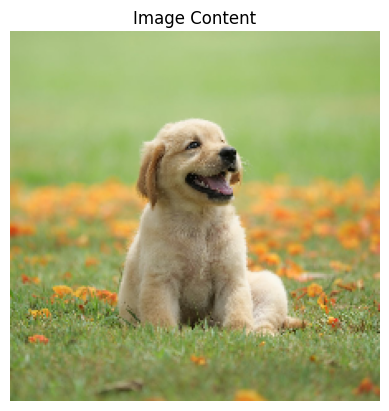

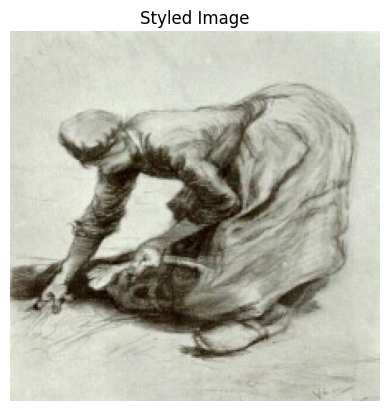

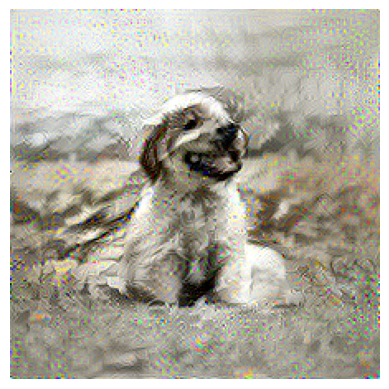

In [254]:

style_image = tf.image.decode_image(tf.io.read_file('/content/images/images/Vincent_van_Gogh/Vincent_van_Gogh_113.jpg'))
content_image = tf.image.decode_image(tf.io.read_file('/content/dog-puppy-on-garden-royalty-free-image-1586966191.jpg'))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
#style_image = (style_image - 0.5) * 2.0

content_image = tf.image.convert_image_dtype(content_image, tf.float32)
#content_image = (content_image - 0.5) * 2.0

style_image = tf.image.resize(style_image, (224, 224))
content_image = tf.image.resize(content_image, (224, 224))
#style_image = tf.keras.applications.vgg19.preprocess_input(style_image)
#content_image = tf.keras.applications.vgg19.preprocess_input(content_image)
plt.imshow(content_image)
plt.title("Image Content")
plt.axis('off')  # Turn off axis labels
plt.show()
plt.imshow(style_image)
plt.title("Styled Image")
plt.axis('off')  # Turn off axis labels
plt.show()
# Add batch dimension
style_image = tf.expand_dims(style_image, axis=0)
content_image = tf.expand_dims(content_image, axis=0)
final_image = model([content_image, style_image])
final_image_display = ((final_image[0]))

# Display the final image
plt.imshow(final_image_display)
plt.axis('off')  # Turn off axis labels
plt.show()

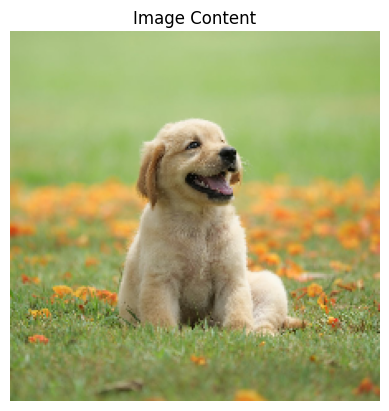

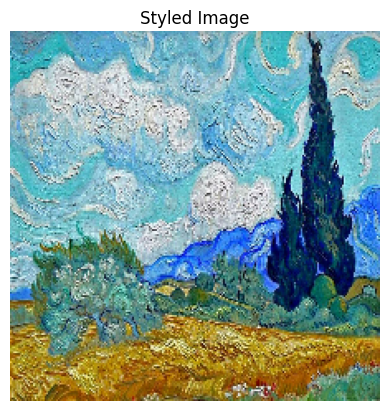

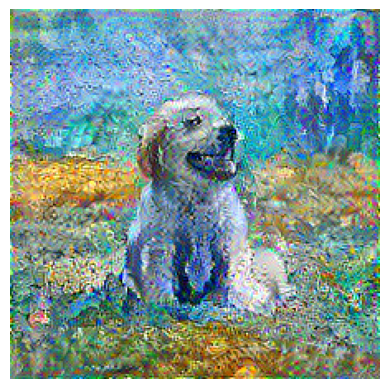

In [251]:

style_image = tf.image.decode_image(tf.io.read_file('/content/images/images/Vincent_van_Gogh/Vincent_van_Gogh_109.jpg'))
content_image = tf.image.decode_image(tf.io.read_file('/content/dog-puppy-on-garden-royalty-free-image-1586966191.jpg'))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
#style_image = (style_image - 0.5) * 2.0

content_image = tf.image.convert_image_dtype(content_image, tf.float32)
#content_image = (content_image - 0.5) * 2.0

style_image = tf.image.resize(style_image, (224, 224))
content_image = tf.image.resize(content_image, (224, 224))
#style_image = tf.keras.applications.vgg19.preprocess_input(style_image)
#content_image = tf.keras.applications.vgg19.preprocess_input(content_image)
plt.imshow(content_image)
plt.title("Image Content")
plt.axis('off')  # Turn off axis labels
plt.show()
plt.imshow(style_image)
plt.title("Styled Image")
plt.axis('off')  # Turn off axis labels
plt.show()
# Add batch dimension
style_image = tf.expand_dims(style_image, axis=0)
content_image = tf.expand_dims(content_image, axis=0)
final_image = model([content_image, style_image])
final_image_display = ((final_image[0]))

# Display the final image
plt.imshow(final_image_display)
plt.axis('off')  # Turn off axis labels
plt.show()

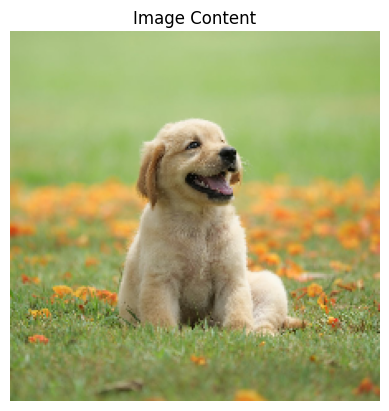

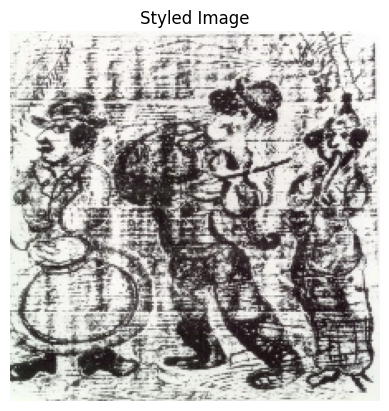

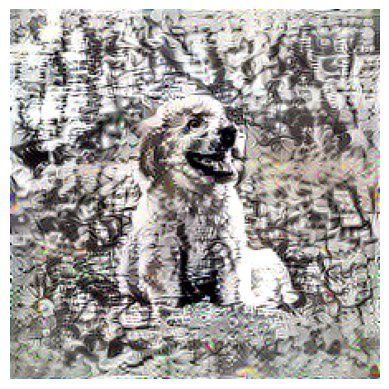

In [252]:

style_image = tf.image.decode_image(tf.io.read_file('/content/images/images/Marc_Chagall/Marc_Chagall_107.jpg'))
content_image = tf.image.decode_image(tf.io.read_file('/content/dog-puppy-on-garden-royalty-free-image-1586966191.jpg'))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
#style_image = (style_image - 0.5) * 2.0

content_image = tf.image.convert_image_dtype(content_image, tf.float32)
#content_image = (content_image - 0.5) * 2.0

style_image = tf.image.resize(style_image, (224, 224))
content_image = tf.image.resize(content_image, (224, 224))
#style_image = tf.keras.applications.vgg19.preprocess_input(style_image)
#content_image = tf.keras.applications.vgg19.preprocess_input(content_image)
plt.imshow(content_image)
plt.title("Image Content")
plt.axis('off')  # Turn off axis labels
plt.show()
plt.imshow(style_image)
plt.title("Styled Image")
plt.axis('off')  # Turn off axis labels
plt.show()
# Add batch dimension
style_image = tf.expand_dims(style_image, axis=0)
content_image = tf.expand_dims(content_image, axis=0)
final_image = model([content_image, style_image])
final_image_display = ((final_image[0]))

# Display the final image
plt.imshow(final_image_display)
plt.axis('off')  # Turn off axis labels
plt.show()

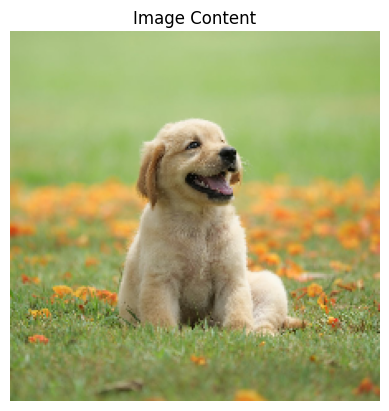

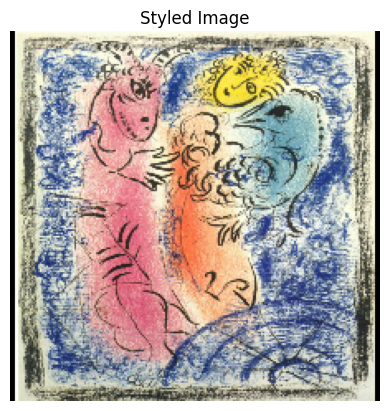

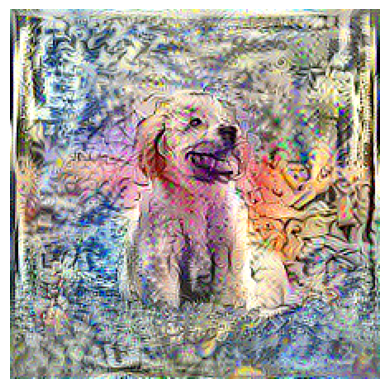

In [253]:

style_image = tf.image.decode_image(tf.io.read_file('/content/images/images/Marc_Chagall/Marc_Chagall_135.jpg'))
content_image = tf.image.decode_image(tf.io.read_file('/content/dog-puppy-on-garden-royalty-free-image-1586966191.jpg'))
style_image = tf.image.convert_image_dtype(style_image, tf.float32)
#style_image = (style_image - 0.5) * 2.0

content_image = tf.image.convert_image_dtype(content_image, tf.float32)
#content_image = (content_image - 0.5) * 2.0

style_image = tf.image.resize(style_image, (224, 224))
content_image = tf.image.resize(content_image, (224, 224))
#style_image = tf.keras.applications.vgg19.preprocess_input(style_image)
#content_image = tf.keras.applications.vgg19.preprocess_input(content_image)
plt.imshow(content_image)
plt.title("Image Content")
plt.axis('off')  # Turn off axis labels
plt.show()
plt.imshow(style_image)
plt.title("Styled Image")
plt.axis('off')  # Turn off axis labels
plt.show()
# Add batch dimension
style_image = tf.expand_dims(style_image, axis=0)
content_image = tf.expand_dims(content_image, axis=0)
final_image = model([content_image, style_image])
final_image_display = ((final_image[0]))

# Display the final image
plt.imshow(final_image_display)
plt.axis('off')  # Turn off axis labels
plt.show()